# 🚢 Titanic classifier

🎯 In this challenge, the goal is to use SVM classifiers to predict whether a passenger survived or not (accuracy score), and compare your performance with your buddy of the day on an unseen test set that you will both share. Be aware that you will only have one trial on the test set!

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(8)

🚢 Import the `Titanic dataset`:

In [ ]:
import seaborn as sns
data = sns.load_dataset('titanic').drop(columns=['alive'])
data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,True


❓ **Question (Game Plan**) ❓ 

Write down below in plain english the different steps you are going to perform to answer the question.

<details><summary>👨🏻‍🏫 <i>Read our answer suggested answer here</i></summary>
    
    
0. 🧹 Data Cleaning
1. ✂️ Train/Test Split
2. 🔡 Feature Encoding
3. ⚖️ Feature Scaling
4. 🐣 A first model
5. 🤖 Model Tuning: Cross-Validated RandomSearch (Coarse Grain approach first, Fine Grain afterwards)
6. 🕵🏻 True performance analysis on the test set
</details>

## (0) 🧹 Data Cleaning

❓ **Question (Duplicated rows)** ❓

Are there any duplicated rows ? If so, drop them.

In [ ]:
print(f"Original shape = {data.shape}")
print(f"Shape after removing duplicates = {data.drop_duplicates().shape}")

data.drop_duplicates(inplace = True)

Original shape = (891, 14)
Shape after removing duplicates = (784, 14)


❓ **Question (Missing values)** ❓

In which columns do we have missing values ?

Drop the column if there are too many missing values or impute these missing values.

In [ ]:
(data.isna().sum()/len(data)).sort_values(ascending = False)

deck           0.742347
age            0.135204
embarked       0.002551
embark_town    0.002551
survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
adult_male     0.000000
alone          0.000000
dtype: float64

In [ ]:
# There are too many missing values in the 'deck' column....
data.drop(columns = ["deck"], inplace = True)

In [ ]:
# To keep things simple, we could impute these with the most frequent values for the other three
from sklearn.impute import SimpleImputer
simple_imputer = SimpleImputer(strategy = "most_frequent")
simple_imputer.fit(data[["embarked", "embark_town", "age"]])
data[["embarked", "embark_town", "age"]] = simple_imputer.transform(data[["embarked", "embark_town", "age"]])

In [ ]:
# You should no longer have missing values
(data.isna().sum()/len(data)).sort_values(ascending = False)

survived       0.0
pclass         0.0
sex            0.0
age            0.0
sibsp          0.0
parch          0.0
fare           0.0
embarked       0.0
class          0.0
who            0.0
adult_male     0.0
embark_town    0.0
alone          0.0
dtype: float64

## (1) ✂️ Holdout

❓ **Question (Train-Test-Split)** ❓ 

* Holdout 30% of your dataset as the test set for a final evaluation  
    * Use `random_state=0` to compare your final results with your buddy's results)

In [ ]:
X = data.drop(columns="survived")
y = data["survived"]


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

## (2) 🔡 Encoding (the categorical variables)

✅ **Encoding the target**

👇 Your target is either `survived` or `died`. It was already done for you as shown down below.

In [ ]:
data.survived.value_counts()

0    461
1    323
Name: survived, dtype: int64

❓ **Question (Encoding the categorical features)** ❓

In [ ]:
data.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
embark_town      object
alone              bool
dtype: object

In [ ]:
categorical_features = ['sex', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alone']

In [ ]:
##############################################
# SOLUTION 1 - Scikit Learn - OneHot Encoder #
##############################################

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop = "if_binary", # Doesn't create an extra column for binary features
                    sparse_output = False, # Returns full matrixes with zeros where need be instead of sparse matrixes
                    handle_unknown="ignore") # Useful to set everything to zero for unseen categories in the test set

ohe.fit(X_train[categorical_features])


ohe.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object),
 array(['First', 'Second', 'Third'], dtype=object),
 array(['child', 'man', 'woman'], dtype=object),
 array([False,  True]),
 array(['Cherbourg', 'Queenstown', 'Southampton'], dtype=object),
 array([False,  True])]

In [ ]:
ohe.get_feature_names_out()

array(['sex_male', 'embarked_C', 'embarked_Q', 'embarked_S',
       'class_First', 'class_Second', 'class_Third', 'who_child',
       'who_man', 'who_woman', 'adult_male_True', 'embark_town_Cherbourg',
       'embark_town_Queenstown', 'embark_town_Southampton', 'alone_True'],
      dtype=object)

In [ ]:
X_train_categorical_encoded = pd.DataFrame(ohe.transform(X_train[categorical_features]),
                                           columns = ohe.get_feature_names_out(),
                                           index = X_train.index)

X_train_categorical_encoded.head()

,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,adult_male_True,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_True
888,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
874,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
263,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
225,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
342,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [ ]:
X_test_categorical_encoded = pd.DataFrame(ohe.transform(X_test[categorical_features]),
                                          columns = ohe.get_feature_names_out(),
                                          index = X_test.index)

X_test_categorical_encoded

,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,adult_male_True,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_True
784,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
89,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
729,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
432,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
867,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
250,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
443,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
829,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
# Dropping the columns that were encoded
features_train = pd.concat([X_train.drop(columns = categorical_features), X_train_categorical_encoded], 
                           axis = 1)
features_test = pd.concat([X_test.drop(columns = categorical_features), X_test_categorical_encoded],
                          axis = 1)

In [ ]:
######################################
# SOLUTION 2 - Pandas - Get Dummies  #
######################################

# dummies_train = pd.get_dummies(X_train[categorical_features])
# data_train = pd.concat([X_train, dummies_train], axis=1).drop(columns=categorical_features)


# dummies_test = pd.get_dummies(X_test[categorical_features])
# data_test = pd.concat([X_test, dummies_test], axis=1).drop(columns=categorical_features)


## (3) ⚖️ Feature Scaling

❓ **Question (Scaling)** ❓

Scale *both* your training set and your test set using the scaler of your choice

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaler.fit(features_train)

features_train_scaled = pd.DataFrame(scaler.transform(features_train), 
                                     columns = features_train.columns,
                                     index = features_train.index)

features_test_scaled = pd.DataFrame(scaler.transform(features_test), 
                                     columns = features_test.columns,
                                     index = features_test.index)

## (4) 🐣 Baseline Model

❓ **Question (Starting with a simple model...) ❓

Cross-validate a Linear SVC model as your baseline model, using the accuracy score. 

In [ ]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

model = SVC(kernel='linear')
cross_val_score(model, features_train_scaled, y_train, cv=5).mean()

CPU times: user 64 ms, sys: 5.2 ms, total: 69.2 ms
Wall time: 66.1 ms


0.7992660550458716

## (5) 🧨 Random Search

❓ **Question (Optimizing a Support Vector Classifier)** ❓

*  Use a **RandomizedSearchCV** to optimize both the parameters `kernel` and `C` of an SVM classifier (SVC)
    - Start with a total of `n_iter=100` combinations, cross-validated `cv=5` times each
    - Use `verbose=1`to check progress
    - Use `n_jobs=-1` to use all your CPU cores
    - (Optional) You can also optimize other parameters of your choice if you want to.

☣️ If the `RandomizedSearchCV` seems stuck after more than 10 seconds, perform one search per SVM kernel. Scikit-Learn sometimes experiences issues with _Searching_ multiple kernels at a time

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

######################
# Instanciate model  #
######################

# $DELETE_BEGIN
model = SVC()
# $DELETE_END

#################################
# Hyperparameters' search space #
#################################

# $DELETE_BEGIN
search_space = {
    'kernel': ['rbf'],
    'C': stats.uniform(0.01, 100),
    'gamma': stats.loguniform(0.001, 100)
    #'degree': stats.randint(1, 5),
}
# $DELETE_END

################################
# Instanciate Random Search    #
################################
# $DELETE_BEGIN

random_search = RandomizedSearchCV(model, 
                                   search_space,
                                   n_jobs=-1, 
                                   scoring='accuracy', 
                                   cv=5, 
                                   n_iter=1000, 
                                   verbose=1)
# $DELETE_END

In [ ]:
%%time
random_search.fit(np.array(features_train_scaled), np.array(y_train))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
CPU times: user 1.07 s, sys: 141 ms, total: 1.21 s
Wall time: 6.18 s


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=1000, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2986e8370>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2986e9660>,
                                        'kernel': ['rbf']},
                   scoring='accuracy', verbose=1)

❓ **Question(Optimized Model and its performance)** ❓

* What are the best parameters ?
* What is the best score?

In [ ]:
random_search.best_params_

{'C': 44.59649948349558, 'gamma': 0.010842322602994356, 'kernel': 'rbf'}

In [ ]:
random_search.best_score_

0.8157297748123435

In [ ]:
best_model = random_search.best_estimator_
# best_model.fit(X_train_scaled, y_train)
# There is no need to fit the best_estimator_, it was already fitted during the GridSearch/RandomSearch!
print(cross_val_score(best_model, features_train_scaled, y_train, cv=5).mean())

0.8157297748123435


## (6) 🕵️‍♀️ Final test score and Confusion Matrix

❓ **Question (Evaluating on the test set)** ❓

* Select the best model you want to test. You will compare your result with your buddy of the day!

* Compute its `accuracy`, `classification_report` and show the `confusion_matrix` on the test set.

☣️ You can only test one model. Once you have seen the test set, any other optimization would result in data leakage 

In [ ]:
from sklearn.metrics import classification_report

# Use the best model for predictions
y_pred = best_model.predict(features_test_scaled)

# Compare predictions and true values to produce classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.11      0.18       139
           1       0.40      0.86      0.55        97

    accuracy                           0.42       236
   macro avg       0.46      0.48      0.36       236
weighted avg       0.47      0.42      0.33       236



❓ **Question (Confusion Matrix)** ❓

/Users/markbotterill/.pyenv/versions/3.10.6/envs/testing-setup/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


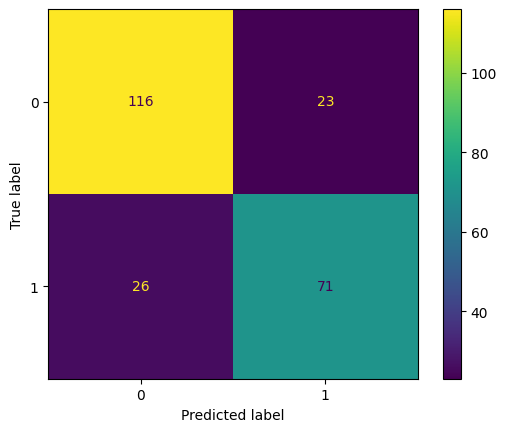

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, features_test_scaled, y_test, );

🏁 Congratulations! You were able to tackle a classification task from A to Z, cleaning your dataset, encoding and scaling your features, optimizing your model... !

💾 Don't forget to git add/commit/push your notebook...

🚀 ... and move on to the next challenge!